In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set the style for the plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_style("darkgrid")
%matplotlib inline

print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")



Pandas version: 3.0.0
NumPy version: 2.4.2


In [5]:
df = pd.read_csv('../data/Exoplanet_Dataset.csv')
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nShape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nFirst 5 rows:")
df.head()

DATASET OVERVIEW

Shape: 5986 rows, 98 columns

First 5 rows:


,name,planet_status,mass,mass_error_min,mass_error_max,mass_sini,mass_sini_error_min,mass_sini_error_max,radius,radius_error_min,...,star_sp_type,star_age,star_age_error_min,star_age_error_max,star_teff,star_teff_error_min,star_teff_error_max,star_detected_disc,star_magnetic_field,star_alternate_names
0,109 Psc b,Confirmed,5.743,0.289,1.011,6.3830,0.078,0.078,1.152,NaN,...,G5 IV,6.90,0.60,0.60,5600.0,80.000,80.000,NaN,NaN,HD 10697
1,112 Psc b,Confirmed,NaN,0.005,0.004,0.0330,0.005,0.004,NaN,NaN,...,G0IV,NaN,NaN,NaN,5986.0,105.437,105.437,NaN,NaN,HD 12235
2,112 Psc c,Confirmed,9.866,1.781,3.190,NaN,NaN,NaN,NaN,NaN,...,G0IV,NaN,NaN,NaN,5986.0,105.437,105.437,NaN,NaN,HD 12235
3,11 UMi b,Confirmed,NaN,1.100,1.100,11.0873,1.100,1.100,NaN,NaN,...,K4III,1.56,0.54,0.54,4340.0,70.000,70.000,NaN,NaN,NaN
4,14 And Ab,Confirmed,NaN,0.230,0.230,4.6840,0.230,0.230,NaN,NaN,...,K0III,NaN,NaN,NaN,4813.0,20.000,20.000,NaN,NaN,NaN


In [6]:
# Define the columns I will use in pipeline
critical_cols = [
    'mass',                # Stage 1 target
    'radius',             # Stage 1 feature + ESI
    'orbital_period',     # Stage 1 feature
    'star_mass',          # Stage 1 feature
    'temp_calculated',    # Stage 2 target + ESI
    'star_teff',          # Stage 2 feature
    'semi_major_axis'     # Stage 2 feature
]

print("="*80)
print("CRITICAL COLUMNS - DATA TYPES AND MISSING VALUES")
print("="*80)

for col in critical_cols:
    total = len(df)
    missing = df[col].isnull().sum()
    available = total - missing
    missing_pct = (missing / total) * 100
    
    print(f"\n{col}")
    print(f"   Available: {available} / {total} ({100-missing_pct:.1f}%)")
    print(f"   Missing: {missing} ({missing_pct:.1f}%)")
    
    if available > 0:
        print(f"   Min: {df[col].min():.4f}")
        print(f"   Max: {df[col].max():.4f}")
        print(f"   Mean: {df[col].mean():.4f}")

CRITICAL COLUMNS - DATA TYPES AND MISSING VALUES

mass
   Available: 2079 / 5986 (34.7%)
   Missing: 3907 (65.3%)
   Min: 0.0002
   Max: 12.9340
   Mean: 1.4925

radius
   Available: 4568 / 5986 (76.3%)
   Missing: 1418 (23.7%)
   Min: 0.0254
   Max: 6.9000
   Mean: 0.4015

orbital_period
   Available: 5691 / 5986 (95.1%)
   Missing: 295 (4.9%)
   Min: 0.0078
   Max: 8035500.0000
   Mean: 2144.3468

star_mass
   Available: 5594 / 5986 (93.5%)
   Missing: 392 (6.5%)
   Min: 0.0110
   Max: 5.5000
   Mean: 0.9334

temp_calculated
   Available: 1983 / 5986 (33.1%)
   Missing: 4003 (66.9%)
   Min: 56.0000
   Max: 3921.0000
   Mean: 935.7579

star_teff
   Available: 5475 / 5986 (91.5%)
   Missing: 511 (8.5%)
   Min: 2200.0000
   Max: 42065.0000
   Mean: 5385.4553

semi_major_axis
   Available: 4435 / 5986 (74.1%)
   Missing: 1551 (25.9%)
   Min: 0.0008
   Max: 22086.0000
   Mean: 13.9921


In [7]:
print("="*80)
print("STAGE-WISE AVAILABLE SAMPLE COUNTS")
print("="*80)

# Stage 1: Mass Prediction
stage1_features = ['radius', 'orbital_period', 'star_mass']
stage1_target = 'mass'
stage1_mask = df[stage1_features + [stage1_target]].notna().all(axis=1)
stage1_count = stage1_mask.sum()

print(f"\nSTAGE 1 - Mass Prediction")
print(f"   Features: radius, orbital_period, star_mass")
print(f"   Target: mass")
print(f"   Available samples: {stage1_count} / {len(df)}")

# Stage 2: Temperature Prediction
stage2_features = ['star_teff', 'semi_major_axis']
stage2_target = 'temp_calculated'
stage2_mask = df[stage2_features + [stage2_target]].notna().all(axis=1)
stage2_count = stage2_mask.sum()

print(f"\nSTAGE 2 - Temperature Prediction")
print(f"   Features: star_teff, semi_major_axis")
print(f"   Target: temp_calculated")
print(f"   Available samples: {stage2_count} / {len(df)}")

# Full Pipeline: All columns must be complete
full_pipeline_cols = ['mass', 'radius', 'orbital_period', 'star_mass', 
                      'temp_calculated', 'star_teff', 'semi_major_axis']
full_mask = df[full_pipeline_cols].notna().all(axis=1)
full_count = full_mask.sum()

print(f"\nFULL PIPELINE (All 3 Stages)")
print(f"   All features + targets complete")
print(f"   Available samples: {full_count} / {len(df)}")

print(f"\n" + "="*80)
print("SUMMARY:")
print(f"   Stage 1: {stage1_count} samples")
print(f"   Stage 2: {stage2_count} samples")
print(f"   Full pipeline: {full_count} samples")
print("="*80)

STAGE-WISE AVAILABLE SAMPLE COUNTS

STAGE 1 - Mass Prediction
   Features: radius, orbital_period, star_mass
   Target: mass
   Available samples: 1521 / 5986

STAGE 2 - Temperature Prediction
   Features: star_teff, semi_major_axis
   Target: temp_calculated
   Available samples: 1881 / 5986

FULL PIPELINE (All 3 Stages)
   All features + targets complete
   Available samples: 973 / 5986

SUMMARY:
   Stage 1: 1521 samples
   Stage 2: 1881 samples
   Full pipeline: 973 samples


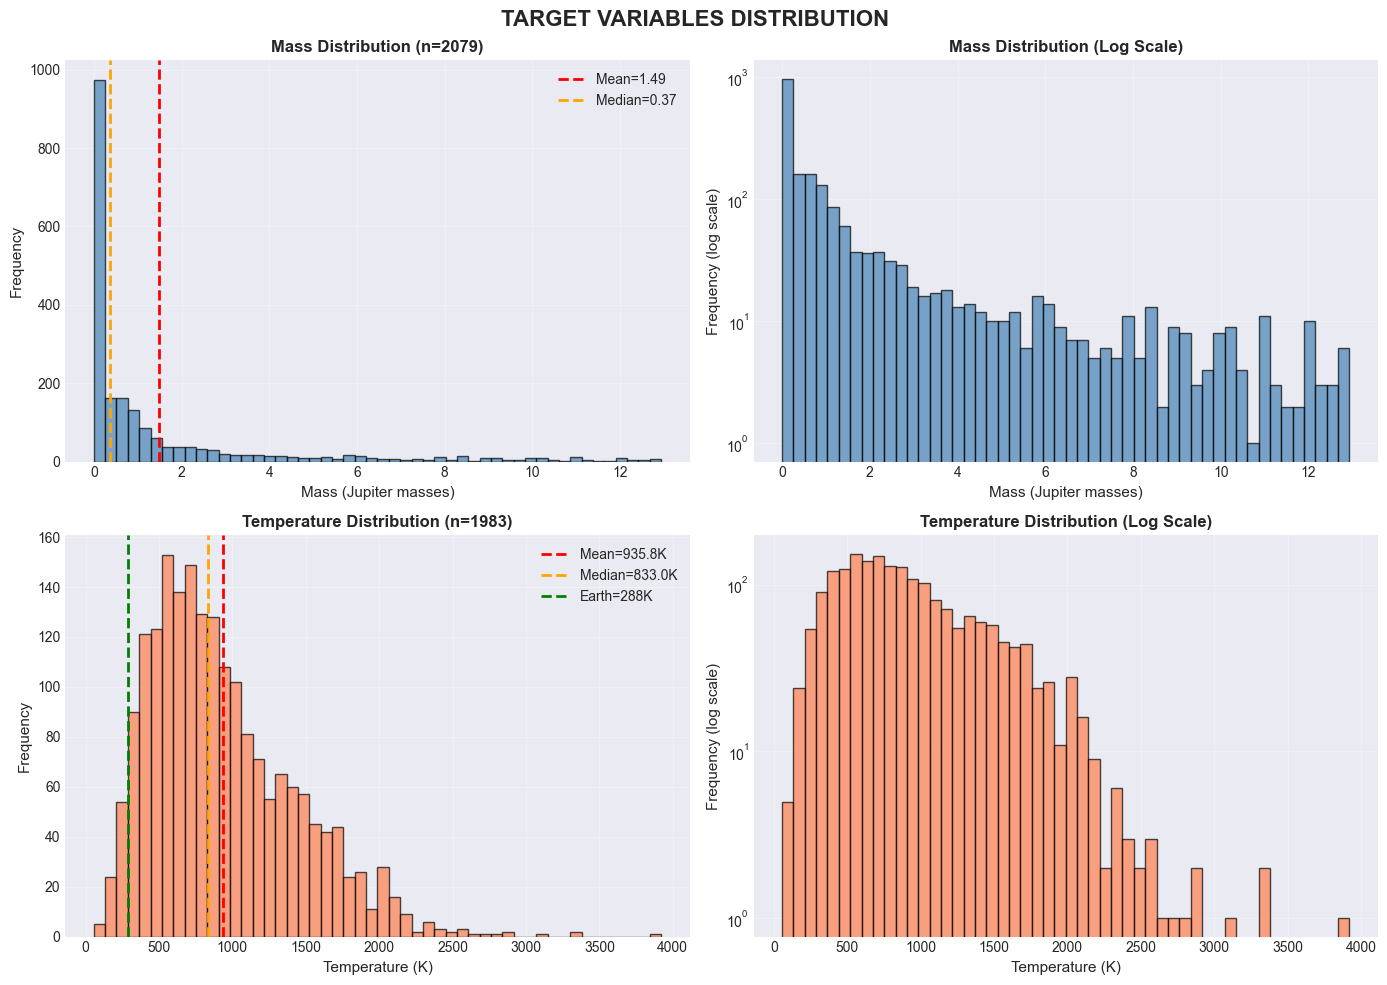

Figure saved: ../outputs/figures/target_distributions.png


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('TARGET VARIABLES DISTRIBUTION', fontsize=16, fontweight='bold')

# 1. Mass Distribution (Normal Scale)
ax1 = axes[0, 0]
mass_data = df['mass'].dropna()
ax1.hist(mass_data, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Mass (Jupiter masses)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title(f'Mass Distribution (n={len(mass_data)})', fontsize=12, fontweight='bold')
ax1.axvline(mass_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={mass_data.mean():.2f}')
ax1.axvline(mass_data.median(), color='orange', linestyle='--', linewidth=2, label=f'Median={mass_data.median():.2f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Mass Distribution (Log Scale)
ax2 = axes[0, 1]
ax2.hist(mass_data, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Mass (Jupiter masses)', fontsize=11)
ax2.set_ylabel('Frequency (log scale)', fontsize=11)
ax2.set_title('Mass Distribution (Log Scale)', fontsize=12, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# 3. Temperature Distribution (Normal Scale)
ax3 = axes[1, 0]
temp_data = df['temp_calculated'].dropna()
ax3.hist(temp_data, bins=50, color='coral', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Temperature (K)', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title(f'Temperature Distribution (n={len(temp_data)})', fontsize=12, fontweight='bold')
ax3.axvline(temp_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={temp_data.mean():.1f}K')
ax3.axvline(temp_data.median(), color='orange', linestyle='--', linewidth=2, label=f'Median={temp_data.median():.1f}K')
ax3.axvline(288, color='green', linestyle='--', linewidth=2, label='Earth=288K')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Temperature Distribution (Log Scale)
ax4 = axes[1, 1]
ax4.hist(temp_data, bins=50, color='coral', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Temperature (K)', fontsize=11)
ax4.set_ylabel('Frequency (log scale)', fontsize=11)
ax4.set_title('Temperature Distribution (Log Scale)', fontsize=12, fontweight='bold')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/target_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: ../outputs/figures/target_distributions.png")

In [9]:
print("="*80)
print("MASS STATISTICS")
print("="*80)
print(mass_data.describe())

print("\n" + "="*80)
print("TEMPERATURE STATISTICS")
print("="*80)
print(temp_data.describe())

# Skewness check
mass_skew = stats.skew(mass_data)
temp_skew = stats.skew(temp_data)

print("\n" + "="*80)
print("SKEWNESS ANALYSIS")
print("="*80)
print(f"Mass Skewness: {mass_skew:.3f}")
print(f"Temperature Skewness: {temp_skew:.3f}")
print("\nNote: |skewness| > 1 indicates highly skewed distribution")
print("      (log transform may be considered)")
print("="*80)

MASS STATISTICS
count    2079.000000
mean        1.492538
std         2.602286
min         0.000190
25%         0.029655
50%         0.370000
75%         1.466500
max        12.934000
Name: mass, dtype: float64

TEMPERATURE STATISTICS
count    1983.000000
mean      935.757892
std       500.467769
min        56.000000
25%       561.000000
50%       833.000000
75%      1230.000000
max      3921.000000
Name: temp_calculated, dtype: float64

SKEWNESS ANALYSIS
Mass Skewness: 2.416
Temperature Skewness: 1.006

Note: |skewness| > 1 indicates highly skewed distribution
      (log transform may be considered)


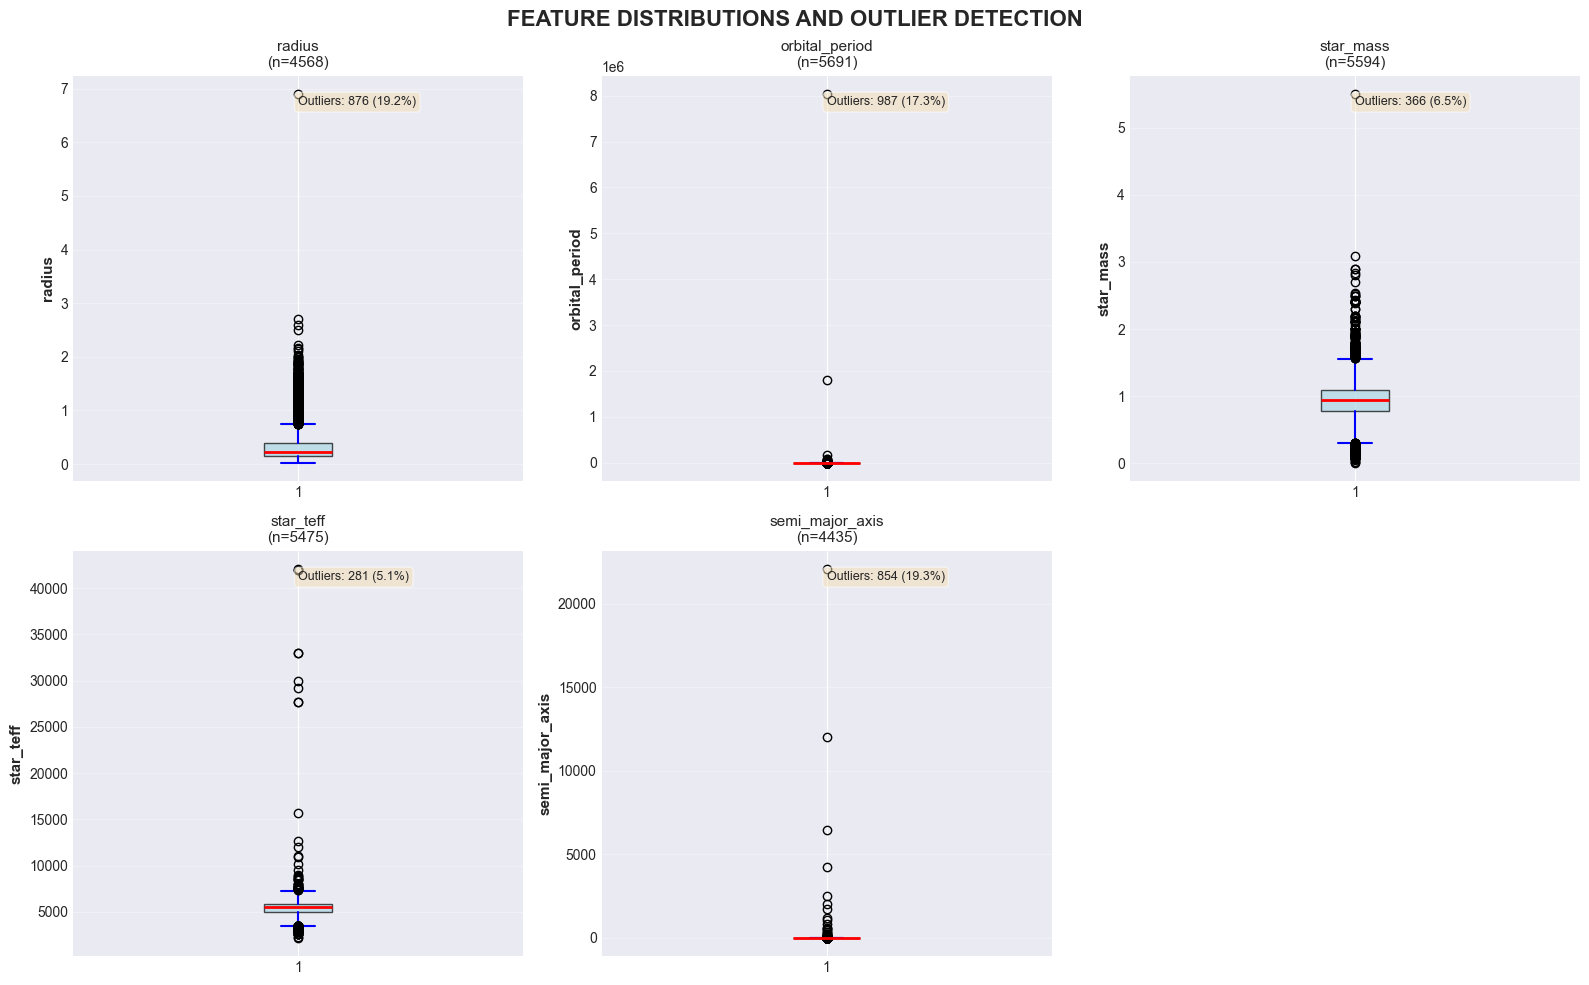

Figure saved: ../outputs/figures/feature_boxplots.png


In [10]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('FEATURE DISTRIBUTIONS AND OUTLIER DETECTION', fontsize=16, fontweight='bold')

features = ['radius', 'orbital_period', 'star_mass', 'star_teff', 'semi_major_axis']

for idx, feature in enumerate(features):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    data = df[feature].dropna()
    
    # Create boxplot
    bp = ax.boxplot(data, vert=True, patch_artist=True, 
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(color='blue', linewidth=1.5),
                     capprops=dict(color='blue', linewidth=1.5))
    
    ax.set_ylabel(feature, fontsize=11, fontweight='bold')
    ax.set_title(f'{feature}\n(n={len(data)})', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Calculate outliers using IQR method
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    
    # Add outlier count to plot
    ax.text(0.5, 0.95, f'Outliers: {outliers} ({outliers/len(data)*100:.1f}%)', 
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Remove empty subplot
axes[1, 2].remove()

plt.tight_layout()
plt.savefig('../outputs/figures/feature_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: ../outputs/figures/feature_boxplots.png")

In [11]:
print("="*80)
print("EDA SUMMARY REPORT")
print("="*80)

print("\nDATA QUALITY:")
print(f"   Stage 1: {stage1_count} samples available")
print(f"   Stage 2: {stage2_count} samples available")
print(f"   Full pipeline: {full_count} samples (matches plan!)")

print("\nDISTRIBUTION ISSUES:")
print(f"   Mass: Skewness={mass_skew:.3f} -> HIGHLY SKEWED")
print("     -> Start with normal scale in MVP")
print("     -> Test log transform in V2")
print(f"   Temperature: Skewness={temp_skew:.3f} -> Slightly skewed")
print("     -> Can proceed with normal scale")

print("\nNEXT STEPS:")
print("   [DONE] EDA Complete")
print("   [NEXT] Stage 1: Mass Prediction model")
print("   [TODO] Linear Regression baseline")
print("   [TODO] Random Forest comparison")

print("\n" + "="*80)

EDA SUMMARY REPORT

DATA QUALITY:
   Stage 1: 1521 samples available
   Stage 2: 1881 samples available
   Full pipeline: 973 samples (matches plan!)

DISTRIBUTION ISSUES:
   Mass: Skewness=2.416 -> HIGHLY SKEWED
     -> Start with normal scale in MVP
     -> Test log transform in V2
   Temperature: Skewness=1.006 -> Slightly skewed
     -> Can proceed with normal scale

NEXT STEPS:
   [DONE] EDA Complete
   [NEXT] Stage 1: Mass Prediction model
   [TODO] Linear Regression baseline
   [TODO] Random Forest comparison

